tensor([[-8.5550,  7.0646],
        [-6.1375, -6.5808],
        [-6.3213, -6.8041],
        [ 4.1805,  1.1233],
        [ 4.3803,  0.4700]]) tensor([3, 2, 2, 1, 1])
tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1, 1, 3, 3, 3,
        1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 3, 2, 1, 3, 3, 1, 2, 1, 3, 1, 3, 0, 1,
        3, 1, 2, 0, 1, 3, 0, 3, 0, 0, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 1, 0, 3, 0,
        1, 2, 1, 3, 1, 0, 1, 0, 2, 0, 0, 0, 1, 3, 2, 2, 0, 0, 0, 0, 1, 1, 3, 1,
        3, 0, 1, 2, 1, 3, 3, 0, 3, 1, 1, 0, 2, 0, 3, 2, 1, 1, 1, 1, 2, 3, 2, 1,
        0, 2, 3, 1, 3, 2, 1, 3, 2, 1, 0, 2, 1, 3, 1, 3, 0, 2, 1, 1, 0, 0, 3, 3,
        3, 1, 1, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 1, 1, 3, 2, 0, 1, 2, 0, 0, 1, 2,
        3, 2, 1, 0, 0, 1, 0, 3, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2, 1, 3, 0, 2, 1, 0,
        1, 1, 0, 3, 2, 2, 2, 3, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 3, 2, 2, 1, 0,
        2, 0, 3, 1, 3, 3, 2, 0, 3, 0, 1, 2, 2, 0, 0, 2, 0, 3, 2, 2, 3, 2, 2, 1,
        2, 3, 2, 1, 3, 0, 1, 0, 1, 

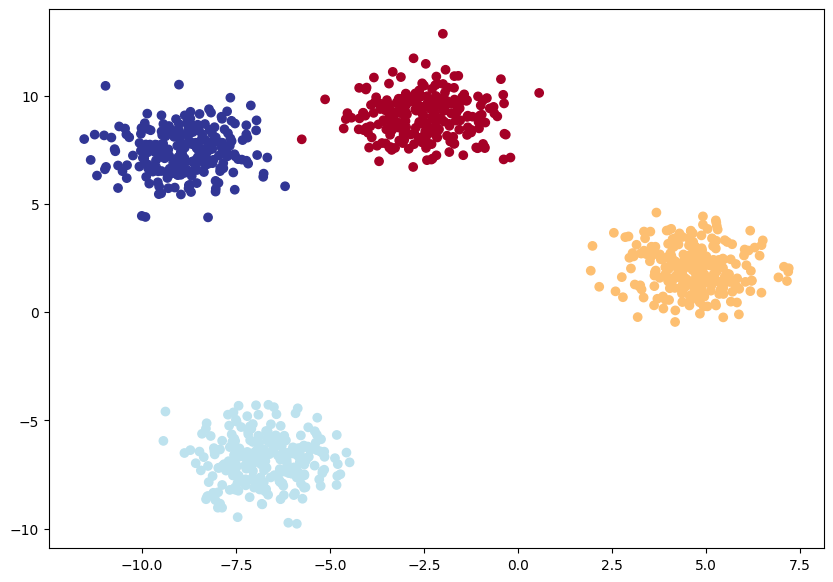

In [4]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);
print(y_blob)

In [5]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [7]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.8708,  1.2922,  1.4060, -0.1500],
        [-2.1029,  1.5602,  3.5141, -0.0617],
        [ 2.0645, -2.1228, -3.9179,  1.9484],
        [ 1.3181, -1.3998, -2.5798,  1.5358],
        [-1.7398,  1.2387,  2.8665,  0.1139]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [8]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [9]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.0409,  1.4002,  1.7048, -0.1969],
        [-1.3970,  0.5048,  2.2085,  0.6376],
        [ 1.8390, -1.8146, -3.5038,  1.7491],
        [-0.5210,  0.9422,  0.7777,  0.0527],
        [-2.2515,  1.8239,  3.7935, -0.2434]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0329, 0.3780, 0.5126, 0.0765],
        [0.0192, 0.1284, 0.7057, 0.1467],
        [0.5142, 0.0133, 0.0025, 0.4700],
        [0.0929, 0.4015, 0.3406, 0.1650],
        [0.0020, 0.1203, 0.8624, 0.0152]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [10]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 3.51868, Acc: 16.75% | Test Loss: 0.42508, Test Acc: 89.50%
Epoch: 10 | Loss: 0.10524, Acc: 99.88% | Test Loss: 0.09616, Test Acc: 100.00%
Epoch: 20 | Loss: 0.05095, Acc: 99.88% | Test Loss: 0.04759, Test Acc: 100.00%
Epoch: 30 | Loss: 0.03244, Acc: 99.88% | Test Loss: 0.03000, Test Acc: 100.00%
Epoch: 40 | Loss: 0.02355, Acc: 99.88% | Test Loss: 0.02140, Test Acc: 100.00%
Epoch: 50 | Loss: 0.01846, Acc: 99.88% | Test Loss: 0.01644, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01520, Acc: 99.88% | Test Loss: 0.01326, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01295, Acc: 99.88% | Test Loss: 0.01107, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01132, Acc: 99.88% | Test Loss: 0.00948, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01008, Acc: 99.88% | Test Loss: 0.00829, Test Acc: 100.00%
Epoch: 100 | Loss: 0.00912, Acc: 99.88% | Test Loss: 0.00736, Test Acc: 100.00%
Epoch: 110 | Loss: 0.00835, Acc: 99.88% | Test Loss: 0.00661, Test Acc: 100.00%
Epoch: 120 | Loss: 0.00771, Acc: 99.88% | Test Loss:

In [12]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  9.9055,  18.4098, -16.2709, -13.0140],
        [  1.0337, -19.8021,   1.1289,  12.0646],
        [-20.9620, -23.8385,  31.6765,  20.2314],
        [  5.5339,  14.8936,  -9.8228,  -9.7748],
        [ 13.7760,   5.0014, -19.6862,  -6.0439],
        [  0.8069, -23.0357,   1.8871,  14.0496],
        [-20.4007, -20.3086,  30.4212,  17.9824],
        [ 11.0187,   0.2630, -15.2694,  -2.4998],
        [-22.7779, -29.8081,  34.9810,  24.2619],
        [ 11.8547,   1.9769, -16.6471,  -3.7394]], device='cuda:0')

In [13]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 100.0%


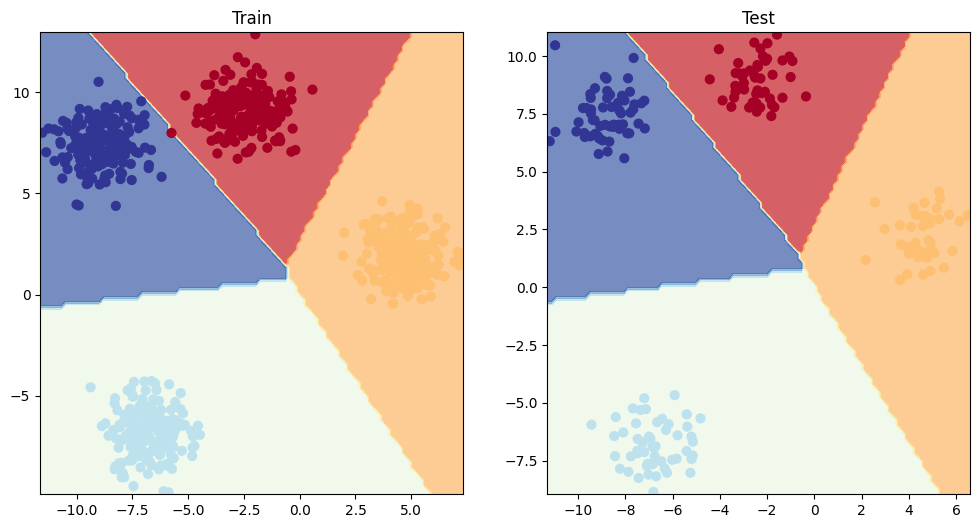

In [14]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)